In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(tf.test.gpu_device_name())

#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))


/device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!pip -q install vit_pytorch linformer
!pip install transformers
!pip install pillow
!pip install tensorflow-addons

!pip install  vit-keras





     |████████████████████████████████| 68 kB 2.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 3.1 MB/s 
     |████████████████████████████████| 101 kB 12.4 MB/s 
     |████████████████████████████████| 6.6 MB 45.3 MB/s 
     |████████████████████████████████| 596 kB 69.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 3.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=46d4c6a8632fb1efa

In [ ]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import tensorflow_addons as tfa


from vit_pytorch.efficient import ViT
from transformers import ViTForImageClassification, ViTFeatureExtractor
from vit_keras import vit

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization, InputLayer, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.mixed_precision import LossScaleOptimizer
from tensorflow.keras.metrics import Recall
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import random
import os
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import random




In [ ]:
print(f"Torch: {torch.__version__}")
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Torch: 1.11.0+cu113
True
Tesla T4


In [ ]:
# Training settings
batch_size = 64
epochs = 30
# lr = 3e-5
lr = 3e-5
gamma = 0.7
seed = 42

In [ ]:

model_name = 'google/vit-base-patch16-224'
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')


Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

In [ ]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [ ]:
data_dir = "/content/drive/My Drive/Malaria-Detection/Dataset"
PARA_DIR = "/content/drive/MyDrive/Malaria-Detection/Dataset/Train/Parasite"

UNIF_DIR = "/content/drive/MyDrive/Malaria-Detection/Dataset/Train/Uninfected"
PARA_DIR_TEST = "/content/drive/MyDrive/Malaria-Detection/Dataset/Train/Parasite"
UNIF_DIR_TEST = "/content/drive/MyDrive/Malaria-Detection/Dataset/Train/Uninfected"

test_dir = "/content/drive/MyDrive/Malaria-Detection/Dataset/Test"

In [ ]:
PARA_LIST = glob.glob(os.path.join(PARA_DIR,'*.png'))
UNIF_LIST = glob.glob(os.path.join(UNIF_DIR,'*.png'))
train_list = PARA_LIST + UNIF_LIST
import random
random.shuffle(train_list)

PARA_LIST_TEST = glob.glob(os.path.join(PARA_DIR_TEST, '*.png'))
UNIF_LIST_TEST = glob.glob(os.path.join(UNIF_DIR_TEST, '*.png'))
test_list = PARA_LIST_TEST + UNIF_LIST_TEST



In [ ]:
print(f"PARA_LIST Data: {len(PARA_LIST)}")
print(f"UNIF_LIST Data: {len(UNIF_LIST)}")
print(f"train_list Data: {len(train_list)}")

print(f"test_list Data: {len(test_list)}")


PARA_LIST Data: 13779
UNIF_LIST Data: 13792
train_list Data: 27571
test_list Data: 27571


In [ ]:
labels = [path.split('/')[-2].split('.')[0] for path in train_list]


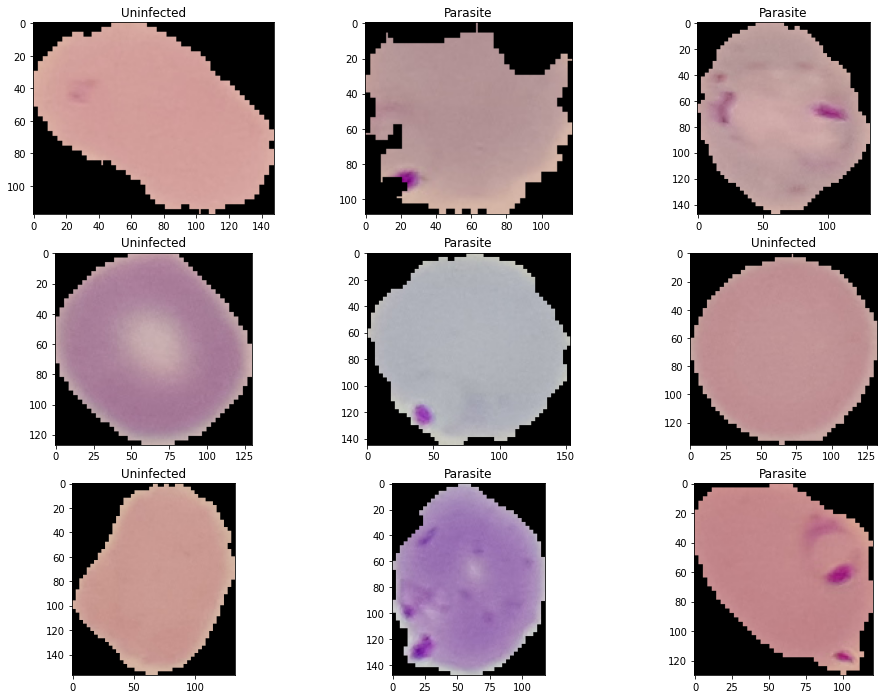

In [ ]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


In [ ]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                  validation_split=0.2) # set validation split

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set_all = train_datagen.flow_from_directory('/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/',
                                                 target_size = (224, 224),
                                                 batch_size = 20,
                                                 class_mode = 'categorical')

In [ ]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/',
                                                 target_size = (224, 224),
                                                 batch_size = 20,
                                                 class_mode = 'categorical',
                                                     subset='training') # set as training data

In [ ]:
validation_data = train_datagen.flow_from_directory('/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/',
                                                 target_size = (224, 224),
                                                 batch_size = 20,
                                                 class_mode = 'categorical',
                                                     subset='validation') # set as validation data

In [ ]:
test_set1 = test_datagen.flow_from_directory('/content/drive/MyDrive/Malaria-Detection/Dataset1/Test/',
                                            target_size = (224, 224),
                                            batch_size = 20,
                                            class_mode = 'categorical',
                                            shuffle= False)

In [ ]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 22056
Validation Data: 5515
Test Data: 27571


In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [ ]:
class MalariaDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-2].split(".")[0]
        label = 1 if label == "Parasite" else 0

        return img_transformed, label


In [ ]:
train_data = MalariaDataset(train_list, transform=train_transforms)
valid_data = MalariaDataset(valid_list, transform=test_transforms)
test_data = MalariaDataset(test_list, transform=test_transforms)


In [ ]:
train_data.__getitem__(1)


(tensor([[[0.7647, 0.7647, 0.7647,  ..., 0.6902, 0.4078, 0.0941],
          [0.7647, 0.7647, 0.7647,  ..., 0.6902, 0.4078, 0.0941],
          [0.7647, 0.7647, 0.7647,  ..., 0.6902, 0.4078, 0.0941],
          ...,
          [0.7333, 0.7333, 0.7333,  ..., 0.0000, 0.0000, 0.0000],
          [0.7373, 0.7373, 0.7373,  ..., 0.0000, 0.0000, 0.0000],
          [0.7373, 0.7373, 0.7373,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.5098, 0.5098, 0.5098,  ..., 0.5176, 0.3059, 0.0706],
          [0.5098, 0.5098, 0.5098,  ..., 0.5176, 0.3059, 0.0706],
          [0.5098, 0.5098, 0.5098,  ..., 0.5176, 0.3059, 0.0706],
          ...,
          [0.4745, 0.4745, 0.4745,  ..., 0.0000, 0.0000, 0.0000],
          [0.4784, 0.4784, 0.4784,  ..., 0.0000, 0.0000, 0.0000],
          [0.4784, 0.4784, 0.4784,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.5333, 0.5333, 0.5333,  ..., 0.4667, 0.2745, 0.0627],
          [0.5333, 0.5333, 0.5333,  ..., 0.4667, 0.2745, 0.0627],
          [0.5333, 0.5333, 0.5333,  ...,

In [ ]:
train_data.__getitem__(1)

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.7686, 0.7686, 0.7686],
          [0.0000, 0.0000, 0.0000,  ..., 0.7686, 0.7686, 0.7686],
          [0.0000, 0.0000, 0.0000,  ..., 0.7686, 0.7686, 0.7686],
          ...,
          [0.7647, 0.7647, 0.7647,  ..., 0.8353, 0.8353, 0.8353],
          [0.7647, 0.7647, 0.7647,  ..., 0.8353, 0.8353, 0.8353],
          [0.7647, 0.7647, 0.7647,  ..., 0.8353, 0.8353, 0.8353]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.5137, 0.5137, 0.5137],
          [0.0000, 0.0000, 0.0000,  ..., 0.5137, 0.5137, 0.5137],
          [0.0000, 0.0000, 0.0000,  ..., 0.5137, 0.5137, 0.5137],
          ...,
          [0.5098, 0.5098, 0.5098,  ..., 0.6118, 0.6118, 0.6118],
          [0.5098, 0.5098, 0.5098,  ..., 0.6118, 0.6118, 0.6118],
          [0.5098, 0.5098, 0.5098,  ..., 0.6118, 0.6118, 0.6118]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.5451, 0.5451, 0.5451],
          [0.0000, 0.0000, 0.0000,  ..., 0.5451, 0.5451, 0.5451],
          [0.0000, 0.0000, 0.0000,  ...,

In [ ]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [ ]:
print(len(train_data), len(train_loader))


22056 345


In [ ]:
print(len(valid_data), len(valid_loader))


5515 87


In [ ]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [ ]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)
model


ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): Linear(in_features=3072, out_features=128, bias=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): FeedForward(
              (w1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (dropout)

In [ ]:
from transformers import ViTForImageClassification, ViTConfig
# from keras.models import Model

# config = ViTConfig.from_pretrained('google/vit-base-patch16-224')

# config.id2label = {
#     0: "UnInfected",
#     1: "Parasite",
# }
# config.label2id = {
#     "Uninfected": 0,
#     "Parasite": 1
# }
# config.ignore_mismatched_sizes= True
# config.num_labels=2


final_label= ["Uninfected", "Parasite"]
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=len(final_label),
    id2label={str(i): c for i, c in enumerate(final_label)},
    label2id={c: str(i) for i, c in enumerate(final_label)},ignore_mismatched_sizes=True).to(device)



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
vit_model = vit.vit_b32(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

import tensorflow as tf

model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()


NameError: ignored

In [ ]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.models import load_model

r1 = model.fit(
  training_set,
  validation_data= validation_data,
  epochs=40,
  batch_size = 20,
  steps_per_epoch=len(training_set),
  # validation_steps=len(validation_data),
  workers=20
)

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer  = optim.Adamax(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=lr)
# optimizer = optim.Adagrad(
#     model.parameters(),
#     lr=0.001,
#     initial_accumulator_value=0.1,
#     eps=1e-07
# )
optimizer = optim.Adadelta(model.parameters(), lr = 0.1)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
torch.cuda.empty_cache()

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        print(output)
        output = output.tensor.argmax(dim=1)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/345 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-image",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [ ]:
y_true=[]
y_pred=[]
count=0
for data, label in valid_loader:
    data = data.to(device)
    label = label.to(device)

    val_output = model(data)
    val_loss = criterion(val_output, label)
    lable_numpy = label.cpu().data.numpy()
    val_numpy = val_output.argmax(dim=1).cpu().data.numpy()
    y_true.extend(lable_numpy)
    y_pred.extend(val_numpy)

    # acc = (val_output.argmax(dim=1) == label).float().mean()
    # epoch_val_accuracy += acc / len(valid_loader)
    # epoch_val_loss += val_loss / len(valid_loader)
print(y_true)
print(y_pred)



[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 

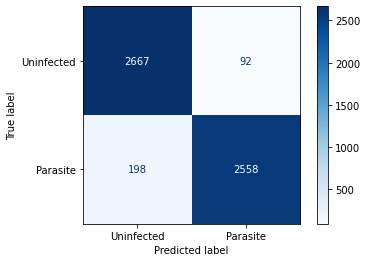

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2759
           1       0.97      0.93      0.95      2756

    accuracy                           0.95      5515
   macro avg       0.95      0.95      0.95      5515
weighted avg       0.95      0.95      0.95      5515



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
labels = ["Uninfected", "Parasite"]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.show()
print(classification_report(y_true, y_pred))


In [ ]:
test_final_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [ ]:
class MalariaTestDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        img_path

        return img_transformed, img_path

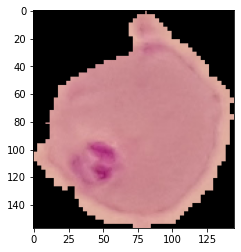

Parasite


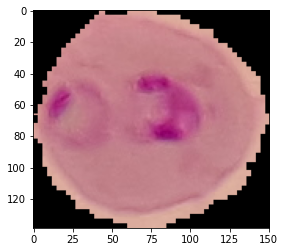

Parasite


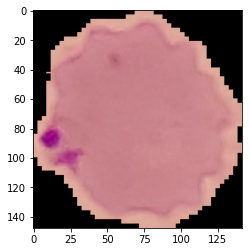

Parasite


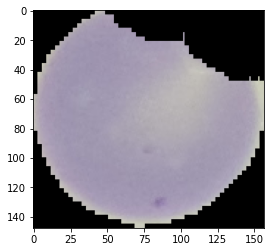

Uninfected


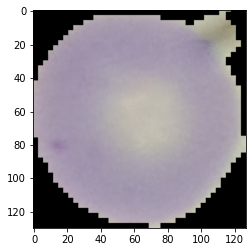

Uninfected


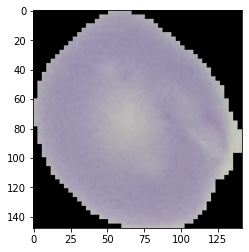

Uninfected


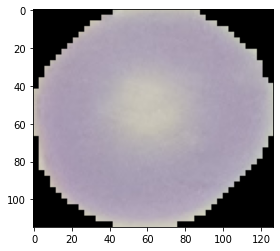

Uninfected


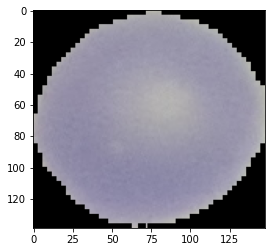

Uninfected


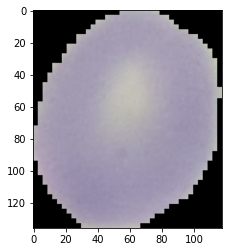

Uninfected


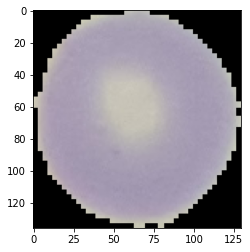

Uninfected


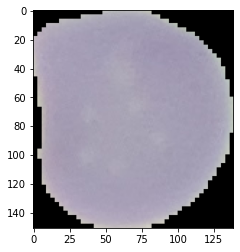

Uninfected


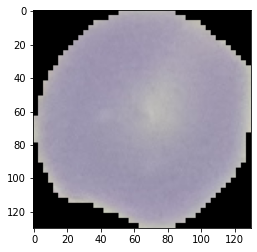

Uninfected


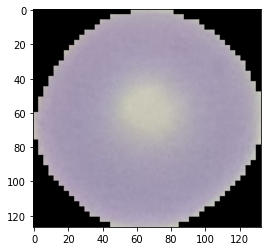

Uninfected


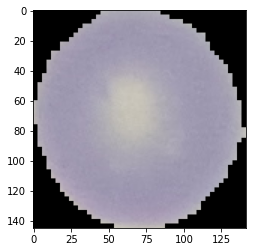

Uninfected


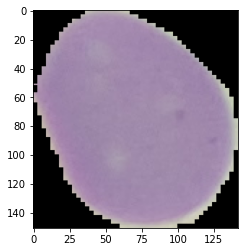

Uninfected


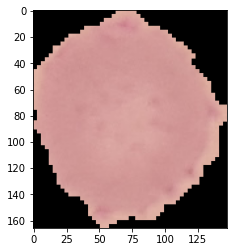

Uninfected


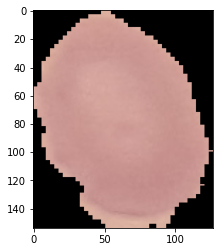

Uninfected


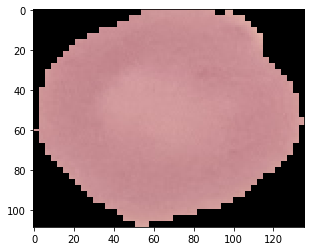

Uninfected


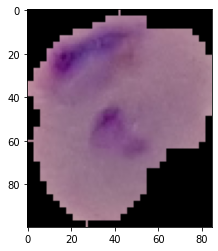

Parasite


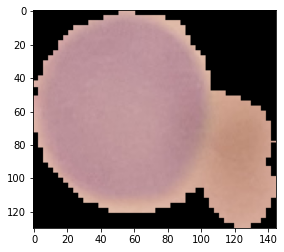

Uninfected


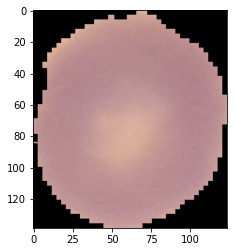

Uninfected


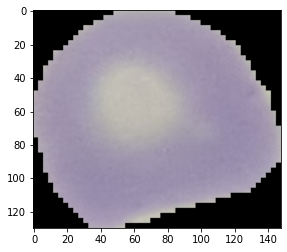

Uninfected


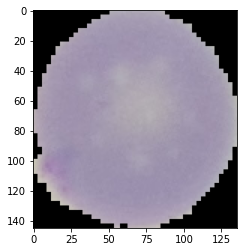

Uninfected


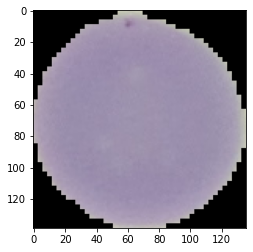

Uninfected


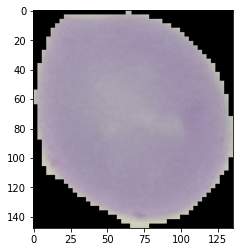

Uninfected


In [ ]:
TestImagesDir = '/content/drive/MyDrive/Malaria-Detection/TestImages'
test_Images_list = glob.glob(os.path.join(TestImagesDir,'*.png'))

test_Images_Data = MalariaTestDataset(test_Images_list, transform=test_final_transforms)

test_Images_Loader = DataLoader(dataset = test_Images_Data, batch_size=1, shuffle=False )

for data,img_path in test_Images_Loader:
  # print(img_path)
  img = Image.open(img_path[0])
  data = data.to(device)
  preds = model(data)
  value = preds.argmax(dim=1)

  plt.imshow(img)
  plt.show()
  if value == 1:
    print("Parasite")
  else :
    print("Uninfected")